In [297]:
import torch
from random import randint
from utilities import chordUtil
from utilities import dataImport
from utilities.chordUtil import *
from utilities.dataImport import *
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random
import sys
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [298]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [299]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
print("using cuda :")
print(use_cuda)
#use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")

use_cuda
True


In [300]:
# Init
lenSeq = 16
#lenSeq = 48
alpha = 'a0'
rootname = "inputs/jazz_xlab/"
filenames = os.listdir(rootname)
#filenames.remove(".DS_Store")
dictChord, listChord = chordUtil.getDictChord(eval(alpha))
print(len(dictChord))
print(dictChord)

25
{'F#:min': 0, 'E:min': 1, 'F:min': 2, 'A:maj': 3, 'D#:min': 4, 'C#:min': 5, 'F#:maj': 6, 'B:maj': 7, 'E:maj': 8, 'G:maj': 9, 'A:min': 10, 'B:min': 11, 'C#:maj': 12, 'C:min': 13, 'D#:maj': 14, 'F:maj': 15, 'A#:min': 16, 'N': 17, 'D:maj': 18, 'G:min': 19, 'G#:maj': 20, 'D:min': 21, 'C:maj': 22, 'G#:min': 23, 'A#:maj': 24}


In [301]:
# Create datasets
files_train ,files_test = train_test_split(filenames,test_size=0.7)
dataset_train = dataImport.ChordSeqDataset(files_train, rootname, alpha, dictChord, lenSeq)
dataset_test = dataImport.ChordSeqDataset(files_test, rootname, alpha, dictChord, lenSeq)


In [302]:
# Create generators
params = {'batch_size': 512,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(dataset_train, **params)
testing_generator = data.DataLoader(dataset_test, **params)


In [308]:
class MYGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,dropout):
        super(MYGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers = num_layers, batch_first = True, dropout = dropout)
        #self.lstm2 = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        self.last_fully_connected = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_batch):
        output, (hidden, cell_state) = self.gru(input_batch)
        #output, (hidden, cell_state) = self.lstm2(output,(hidden, cell_state))
        #print(output.size(), hidden.size(), cell_state.size())
        output = output[:,-1,:]
        #hidden = hidden[-1,:,:]
        #cell_state = cell_state[-1,:,:]
        #output = torch.cat((output,hidden,cell_state),1)
        output = self.last_fully_connected(output)
        output = self.softmax(output)

        return output

In [309]:
def train(local_batch, local_labels):

    optimizer.zero_grad()
    loss = 0
    
    correct_guess, wrong_guess = 0, 0

    # if tensor of shape 1 in loss function (ex : CrossEntropy)
    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    
    
    
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)    
    
    #output, (hidden, cell_state) = lstm_nn(local_batch)
    #output = output[:,-1,:]
    
    output = gru_nn(local_batch)
    #print(output.size())
    
    for i in range(len(local_batch)):
        #print(output[i].size(), local_labels[i].size())
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    
    
    
    loss = criterion(output, local_labels_argmax)
    #loss = criterion(output, local_labels)

    #print(output.size(),local_labels.size())
    
    loss.backward()
    optimizer.step()


    return output, loss.item() / len(local_batch), correct_guess, wrong_guess

In [310]:
def test(local_batch, local_labels):
    loss = 0
    
    correct_guess, wrong_guess = 0, 0

    # if tensor of shape 1 in loss function (ex : CrossEntropy)
    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    
    
    
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)
    
    #output, (hidden, cell_state) = lstm_nn(local_batch)
    #output = output[:,-1,:]
    
    output = gru_nn(local_batch)

    
    for i in range(len(local_batch)):
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    loss = criterion(output, local_labels_argmax)
    #loss = criterion(output, local_labels)

    return output, loss.item() / len(local_batch), correct_guess, wrong_guess
    

# Attention

Ici, soit on crée un nouveau réseau, soit on charge un réseau déjà entraîné.

Réseaux déjà entraînés (si non précisé, dropout = 0.1) :

    - "models/lstm_2layers_256blocks_a0.pt"
    - "models/lstm_2layers_256blocks_a1.pt"
    - "models/lstm_2layers_512blocks_a1_dropout=0.pt"
    - "models/lstm_2layers_512blocks_a1.pt"
    - "models/lstm_2layers_512blocks_a1.pt"

In [306]:
#Init new model

#lstm_nn = nn.LSTM(len(dictChord), len(dictChord), num_layers = lenSeq*5, batch_first = True, dropout = 0.1).to(device)
gru_nn = MYGRU(input_size = len(dictChord), hidden_size = 512, num_layers = 2, dropout = 0.1).to(device)


In [311]:
# Or Load previous model
gru_nn = torch.load("models/gru_2layers_512blocks_a0.pt").to(device)

In [312]:
save = True
save_path = "models/gru_2layers_512blocks_a0.pt"
gru_nn.train(mode=True)



all_losses = []
test_losses = []
total_loss = 0 # Reset every plot_every iters
test_loss = 0

correct_guess_train, wrong_guess_train, correct_guess_test, wrong_guess_test = 0, 0, 0, 0
accuracy_test = []
accuracy_train = []

update_plot = False


start = time.time()

optimizer = torch.optim.Adam(gru_nn.parameters(), lr = 1e-4)
#print(lstm_nn.parameters())
#optimizer = torch.optim.SGD(lstm_nn.parameters(), lr = 5e2, momentum=0.9)


#criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()


print_every = 1
plot_every = 1
max_epochs = 10


# Begin training
print("Start training")
for epoch in range(1, max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        output, loss, correct_guess, wrong_guess = train(local_batch, local_labels)
        #print(loss)
        total_loss += loss
        correct_guess_train += correct_guess
        wrong_guess_train += wrong_guess

    if epoch % print_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        print('%s (%d %d%%) train, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        all_losses.append(total_loss / (plot_every ))
        accuracy_train.append(accuracy*100)
        total_loss = 0
        correct_guess_train, wrong_guess_train = 0, 0

        

    # Testing
    for local_batch, local_labels in testing_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output, loss, correct_guess, wrong_guess  = test(local_batch, local_labels)
        test_loss +=loss
        
        correct_guess_test += correct_guess
        wrong_guess_test += wrong_guess
        

    if epoch % print_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        print('%s (%d %d%%) test, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        test_losses.append(test_loss / (plot_every ))
        accuracy_test.append(accuracy*100)
        test_loss = 0
        correct_guess_test, wrong_guess_test = 0, 0
        
        
#experimental feature : plot in realtime
    if update_plot and plot_every ==1:
        if epoch == 1:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            print(range(epoch), accuracy_test)
            li, = ax.plot(epoch, accuracy_test)
            
            ax.relim() 
            ax.autoscale_view(True,True,True)
            fig.canvas.draw()
            plt.show(block=False)
        time.sleep(0.01)
        li.set_data(list(range(epoch)),accuracy_test)
        time.sleep(0.01)
        fig.canvas.draw()
        
print("Finished training")
if save:
    torch.save(gru_nn, save_path)
    


Start training
0m 0s (1 10%) train, loss : 0.0042, accuracy : 67.4091%
0m 1s (1 10%) test, loss : 0.0027, accuracy : 71.0988%
0m 1s (2 20%) train, loss : 0.0034, accuracy : 68.5815%
0m 2s (2 20%) test, loss : 0.0027, accuracy : 69.6939%
0m 3s (3 30%) train, loss : 0.0039, accuracy : 69.2849%
0m 3s (3 30%) test, loss : 0.0028, accuracy : 68.6402%
0m 4s (4 40%) train, loss : 0.0038, accuracy : 69.0504%
0m 5s (4 40%) test, loss : 0.0027, accuracy : 69.9448%
0m 5s (5 50%) train, loss : 0.0035, accuracy : 69.4021%
0m 6s (5 50%) test, loss : 0.0029, accuracy : 67.7371%
0m 6s (6 60%) train, loss : 0.0038, accuracy : 68.5815%
0m 7s (6 60%) test, loss : 0.0028, accuracy : 69.5434%
0m 8s (7 70%) train, loss : 0.0040, accuracy : 69.9883%
0m 8s (7 70%) test, loss : 0.0029, accuracy : 69.7943%
0m 9s (8 80%) train, loss : 0.0037, accuracy : 68.6987%
0m 10s (8 80%) test, loss : 0.0029, accuracy : 68.3894%
0m 10s (9 90%) train, loss : 0.0036, accuracy : 69.4021%
0m 11s (9 90%) test, loss : 0.0027, acc

/home/valentinbilot/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type MYGRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


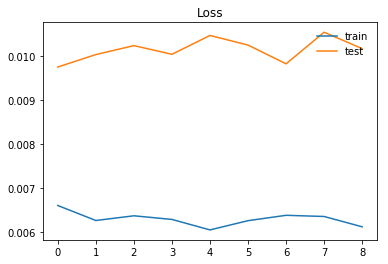

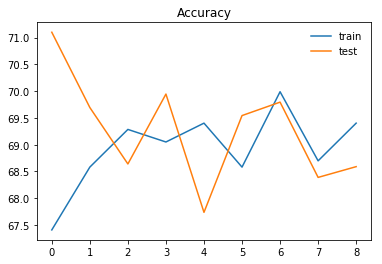

In [313]:
plt.figure()
plt.title("Loss")
plt.plot(all_losses, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(test_losses, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(accuracy_train, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(accuracy_test, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()

# Test avec une grille blues

C'est un peu nul, j'ai l'impression que plus le réseau est entraîné, plus il renvoie des trucs nuls...

In [53]:
if lenSeq == 16:

    test_sequence = ["C:maj","F:maj","C:maj","C:maj",
                     "F:maj","F:maj","C:maj","C:maj",
                     "G:maj","F:maj","C:maj","G:maj",
                     "C:maj","C:maj","F:maj","G:maj"]
    if alpha == 'a5':
        test_sequence = ["C:maj","D:min","D:maj","E:min",
                         "E:min","E:maj","F:min","F:maj",
                         "G:min","G:maj","A:min","A:maj",
                         "B:min","B:maj","C:min","C:maj"]

if lenSeq == 48:
    test_sequence = ["C:maj","C:maj","C:maj","C:maj","F:maj","F:maj","F:maj","F:maj",
                    "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
                    "F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj",
                    "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
                    "G:maj","G:maj","G:maj","G:maj","F:maj","F:maj","F:maj","F:maj",
                    "C:maj","C:maj","C:maj","C:maj","G:maj","G:maj","G:maj","G:maj"]
    


test_sequence = test_sequence[0:lenSeq]
test_sequence_tensor = torch.zeros(1, len(test_sequence), len(dictChord)).to(device)
last_chords_output = torch.zeros(1, lenSeq, len(dictChord)).to(device)
test_sequence_tensor.requires_grad = False
last_chords_output.requires_grad = False
for t in range(len(test_sequence)):
    test_sequence_tensor[0, t, dictChord[test_sequence[t]]] = 1
    if t != len(test_sequence)-1 :
        last_chords_output[0, t-1, dictChord[test_sequence[t]]] = 1



In [324]:
generation_lenght = 120

generated_sequence = [0 for i in range(generation_lenght)]
generated_sequence[0:lenSeq] = test_sequence

gru_nn.train(mode=False)
softmax = nn.Softmax(dim=0)

#Experimental
from random import choices
sampling = True


for t in range(generation_lenght-lenSeq):
    if t == 0:
        output_probability = gru_nn(test_sequence_tensor)
        
        if sampling:
            choice = choices(range(len(listChord)),softmax(output_probability[0]))[0]
            generated_sequence[t+lenSeq] = listChord[choice]
            last_chords_output[0, lenSeq-1, choice] = 1
            
        else: 
            generated_sequence[t+lenSeq] = listChord[torch.argmax(output_probability).item()]
            last_chords_output[0, lenSeq-1, torch.argmax(output_probability).item()] = 1
            
            
    else:
        
        last_chords_output.to(device)        
        output_probability = gru_nn(last_chords_output)
        last_chords_output[0,0:lenSeq-1] = last_chords_output[0,1:lenSeq]
        
        if sampling:
            choice = choices(range(len(listChord)),softmax(output_probability[0]))[0]
            generated_sequence[t+lenSeq] = listChord[choice]
            last_chords_output[0, lenSeq-1, choice] = 1
            
        else:
            last_chords_output[0, lenSeq-1, torch.argmax(output_probability).item()] = 1
            generated_sequence[t+lenSeq] = listChord[torch.argmax(output).item()]
    
        


        

        
for i in range(generation_lenght):
    if i%4 == 0:
        print(generated_sequence[i:i+4])
    if i == lenSeq-1 :
        print("generated :")

['C:maj', 'F:maj', 'C:maj', 'C:maj']
['F:maj', 'F:maj', 'C:maj', 'C:maj']
['G:maj', 'F:maj', 'C:maj', 'G:maj']
['C:maj', 'C:maj', 'F:maj', 'G:maj']
generated :
['G:maj', 'E:min', 'D:maj', 'E:min']
['D:maj', 'E:min', 'G:maj', 'G:maj']
['A:maj', 'G:maj', 'D:maj', 'D:maj']
['D:maj', 'D:maj', 'B:min', 'E:min']
['E:min', 'E:min', 'G:maj', 'A:maj']
['D:maj', 'E:min', 'G:maj', 'D:maj']
['A:maj', 'D:maj', 'G:maj', 'D:maj']
['D:maj', 'G:maj', 'G:maj', 'A:maj']
['D:maj', 'D:maj', 'E:min', 'D:maj']
['E:min', 'A:maj', 'D:maj', 'D:maj']
['D:maj', 'D:maj', 'E:min', 'B:min']
['D:maj', 'D:maj', 'D:maj', 'B:min']
['D:maj', 'D:maj', 'D:maj', 'E:min']
['D:min', 'D:maj', 'G:maj', 'D:maj']
['G:maj', 'G:maj', 'D:maj', 'B:min']
['G:maj', 'B:min', 'G:maj', 'E:min']
['B:min', 'D:maj', 'E:min', 'D:maj']
['B:min', 'E:min', 'D:maj', 'E:min']
['B:min', 'D:maj', 'B:min', 'D:maj']
['D:maj', 'E:min', 'B:min', 'D:maj']
['G:maj', 'B:min', 'D:maj', 'D:maj']
['E:min', 'E:min', 'D:maj', 'E:min']
['D:maj', 'A:maj', 'A:maj'

In [55]:
from random import choices
pop = range(5)
weights = [0,0,0.5,0.5,0]
for i in range(10):
    print(choices(pop, weights))

[3]
[2]
[2]
[3]
[3]
[2]
[2]
[3]
[2]
[3]


In [170]:
output_no_grad = output.detach()
print(choices(range(len(listChord)),output_no_grad[0])[0])

0


In [256]:
print(output_no_grad[0].cpu().numpy())
print(torch.argmax(output))
print(choices(population = range(len(listChord)), weights = list(output_no_grad[0].cpu().numpy()), k=1))
print(choices(range(len(listChord)), output[0]))

[-1.9855236e+01 -1.6212435e+01 -1.4668705e+01 -1.8018471e+01
 -2.3736279e+01 -2.2198736e+01 -1.8832458e+01 -1.8929234e+01
 -2.1338343e+01 -6.6570110e+00 -1.6865717e+01 -2.1663849e+01
 -1.7167353e+01 -1.3026882e+01 -1.7743002e+01 -6.6188231e+00
 -1.9809566e+01 -1.0916405e+01 -1.4416926e+01 -9.6888771e+00
 -1.9735956e+01 -1.2009451e+01 -2.7151108e-03 -2.1254776e+01
 -1.3116481e+01]
tensor(22, device='cuda:0')
[0]


IndexError: range object index out of range

In [283]:
print(choices(range(len(listChord)),output_probability[0])[0])

0


In [322]:
print(softmax((output_probability[0])))

tensor([0.0003, 0.0054, 0.0002, 0.0029, 0.0001, 0.0002, 0.0004, 0.0014, 0.0029,
        0.9070, 0.0166, 0.0008, 0.0004, 0.0019, 0.0006, 0.0052, 0.0002, 0.0073,
        0.0184, 0.0027, 0.0004, 0.0137, 0.0086, 0.0001, 0.0022],
       device='cuda:0', grad_fn=<SoftmaxBackward>)


/home/valentinbilot/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.
